# Code handout - Assignment 4 - Satellite

In this assignment, you will write a small simulator for a satellite in orbit.
In order to simulate and render the satellite, you will need to write some code.
However, some of the code is already written for you (mostly the visualization).

The handout is split into two sections; the pre-written visualization code and the simulation code where some parts are missing.
It is not strictly necessary to understand the first section, but since you will be editing the codee in the second section,
it may be beneficial to figure out how it works.

Good luck!

## Zeroth section: imports

For this assingment we will need:
- NumPy for vectors/matrices
- Matplotlib for animating the satellite
- SciPy for solving the ODEs and for rotation matrices

You may want to add more imports, but it should be necessary to do everything with this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.spatial.transform import Rotation

## First section: visualization

It is not necessary to edit this code.

`drawFrame` will draw the rotated reference frame of the satellite,
`drawBox` will draw the actual satellite
and `make_animation_update_function` will give us the `update`-function that will animate the movement.

In [2]:

def draw_frame(ax, origin, R, scale, label, color):
    """Draws a coordinate frame at a given origin with rotation matrix R."""
    x_axis = scale * R[:, 0]
    y_axis = scale * R[:, 1]
    z_axis = scale * R[:, 2]
    
    ax.quiver(*origin, *(x_axis), color=color[0], label=f'{label}_x')
    ax.quiver(*origin, *(y_axis), color=color[1], label=f'{label}_y')
    ax.quiver(*origin, *(z_axis), color=color[2], label=f'{label}_z')

In [3]:
def draw_box(ax, center, R, size):
    """Draws a box with given size and orientation."""
    # Define box vertices (cube centered at origin)
    l, w, h = size
    vertices = np.array([
        [-l/2, -w/2, -h/2],
        [ l/2, -w/2, -h/2],
        [ l/2,  w/2, -h/2],
        [-l/2,  w/2, -h/2],
        [-l/2, -w/2,  h/2],
        [ l/2, -w/2,  h/2],
        [ l/2,  w/2,  h/2],
        [-l/2,  w/2,  h/2],
    ]).T

    # Transform vertices by rotation and translation
    vertices = R @ vertices + center[:, np.newaxis]

    # Define the faces of the box
    faces = [
        [0, 1, 2, 3],  # Bottom face
        [4, 5, 6, 7],  # Top face
        [0, 1, 5, 4],  # Front face
        [2, 3, 7, 6],  # Back face
        [0, 3, 7, 4],  # Left face
        [1, 2, 6, 5],  # Right face
    ]

    # Plot each face
    for face in faces:
        ax.plot_trisurf(
            vertices[0, face],
            vertices[1, face],
            vertices[2, face],
            color=[0.5, 0.5, 0.5, 0.6],
            shade=True
        )

In [4]:
def make_animation_update_function(ax, states, times, b_r_s, with_added_mass = False):
    """Wraps `update` in a scope containing the relevant variables to animate the satellite trajectory
    using only the video frame number `frame`."""
    def update(frame):
        ax.cla()
        ax.set_xlim([1, 4])
        ax.set_ylim([1, 4])
        ax.set_zlim([1, 4])
        
        state_animate = states[frame]
        i_r_c = state_animate[0:3] * 1e-7
        q = state_animate[3:7]
        vel = state_animate[7:10]
        ang_vel = state_animate[10:13]
        q = q / np.linalg.norm(q)  # Normalize quaternion
        R_mat = Rotation.from_quat(q).as_matrix()

        if with_added_mass:
            i_r_o = i_r_c + R_mat @ b_r_s
        else:
            i_r_o = i_r_c
        
        # Draw satellite and frame
        draw_box(ax, i_r_o, R_mat, size=(1, 1, 1))
        
        draw_frame(ax, (1.5, 1.5, 1.5), 
                   Rotation.from_euler("zyx", (0, 0, 0)).as_matrix(), 
                   scale=1, label="Reference", color=["k", "k", "k"])
        draw_frame(ax, i_r_o, R_mat, 
                   scale=1, label='Body', color=['r', 'g', 'b'])

        ax.quiver(*i_r_o, *(R_mat @ ang_vel), 
                  length=1, pivot="middle", color="k")

        ax.set_title(f"Time: {times[frame]:.2f}s")
        
        return ax,
    return update

## Satellite dynamics

In order to simulate the dynamics of the satellite, we need the ODEs for the state variables.
The `make_satellite_dynamics`-function will return exactly this.
However, there are some expressions missing that you will have to fill in!

In [5]:
def Omega_mx(omega_vec):
    wx = omega_vec[0]
    wy = omega_vec[1]
    wz = omega_vec[2]

    return np.matrix([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

def make_satellite_dynamics(b_M_c, G, m_T):
    # Mimics partial function application binding b_M_c, G and m_T
    def satellite_dynamics(t, x):
        i_r_c = x[0:3]
        q = x[3:7]
        i_v_c = x[7:10]
        b_omega_ib = x[10:13]

        # Kinematics
        i_r_c_dot = i_v_c[:]
        q_dot = 0.5 * Omega_mx(b_omega_ib) @ q

        # Dynamics
        i_v_c_dot = - (G * m_T / np.linalg.norm(i_r_c)**2) * (i_r_c / np.linalg.norm(i_r_c))
        b_omega_ib_dot = np.linalg.inv(b_M_c) @ (
            np.cross(-b_omega_ib, b_M_c @ b_omega_ib)
        )

        state_dot = np.zeros_like(x)
        state_dot[0:3] = i_r_c_dot[:]
        state_dot[3:7] = q_dot[:]
        state_dot[7:10] = i_v_c_dot[:]
        state_dot[10:13] = b_omega_ib_dot[:]

        return state_dot

    return satellite_dynamics

### Simulation

Now, we can simulate the satellite trajectory!

In [37]:
# Constants
earth_radius = 6356e+3
orbit_height = 36000e+3
azi = np.pi / 4
dec = np.pi / 4
# Initial state
pos = (earth_radius + orbit_height) * \
    np.array([
        np.sin(dec) * np.cos(azi),
        np.sin(dec) * np.sin(azi),
        np.cos(dec)
        ])
q = Rotation.random().as_quat()
vel = np.zeros((3,))
ang_vel = np.array([np.deg2rad(60), np.deg2rad(80), np.deg2rad(100)])
state = np.hstack((pos, q, vel, ang_vel))

# Parameters
m_T = 5.972e+24
G = 6.67e-11
l = 0.5
rho = 1
m = rho * l**3
b_M_c = (m * (l**2) / 6) * np.eye(3)

with_added_mass = False

if with_added_mass:
    m_added = 0.1
    b_r_0 = l * np.ones((3,))
    b_r_s = -m_added / (m + m_added) * b_r_0
    b_M_o = (m * (l**2) / 6) * np.eye(3) \
        + m_added * (np.linalg.norm(b_r_0)**2 * np.eye(3) - np.outer(b_r_0, b_r_0))
    b_M_c = b_M_o - (m + m_added) * (np.linalg.norm(b_r_s)**2 * np.eye(3) - np.outer(b_r_s, b_r_s))
else:
    b_r_s = np.zeros((3,))

satellite_dynamics = make_satellite_dynamics(b_M_c, G, m_T)
time_final = 10
result = solve_ivp(satellite_dynamics, (0, time_final), state, 
                    t_eval = np.linspace(0, time_final, num=13037))
time = result.t
state_trajectory = result.y
pos = (1e-7 * state_trajectory[0:3]).T
#i_r_o = i_r_c + R_mat @ b_r_s
rot = state_trajectory[3:7].T

In [7]:
b_r_s

array([-0.22222222, -0.22222222, -0.22222222])

In [8]:
pos.T[:, :10]

array([[2.1178    , 2.1178    , 2.1178    , 2.1178    , 2.1178    ,
        2.1178    , 2.1178    , 2.1178    , 2.1178    , 2.1178    ],
       [2.1178    , 2.1178    , 2.1178    , 2.1178    , 2.1178    ,
        2.1178    , 2.1178    , 2.1178    , 2.1178    , 2.1178    ],
       [2.99502148, 2.99502148, 2.99502148, 2.99502148, 2.99502148,
        2.99502148, 2.99502148, 2.99502148, 2.99502148, 2.99502148]])

In [9]:
rot.T[:, :10]

array([[-0.00540996, -0.00644456, -0.00747933, -0.00851425, -0.00954934,
        -0.01058459, -0.01162   , -0.01265557, -0.0136913 , -0.01472718],
       [ 0.84517742,  0.84576923,  0.84636037,  0.84695082,  0.84754061,
         0.84812972,  0.84871815,  0.84930591,  0.84989299,  0.8504794 ],
       [ 0.38640752,  0.38585905,  0.38530964,  0.3847593 ,  0.38420802,
         0.38365581,  0.38310266,  0.38254858,  0.38199357,  0.38143762],
       [ 0.36923581,  0.36961894,  0.37000231,  0.37038594,  0.37076981,
         0.37115394,  0.37153831,  0.37192293,  0.37230781,  0.37269293]])

In [10]:
cube_center.T[:, :10]

array([[2.20709075, 2.20737622, 2.20765994, 2.20794192, 2.20822214,
        2.20850062, 2.20877736, 2.20905234, 2.20932557, 2.20959705],
       [1.7545362 , 1.75482449, 1.75511474, 1.75540694, 1.7557011 ,
        1.75599719, 1.75629523, 1.75659519, 1.75689709, 1.7572009 ],
       [3.0856566 , 3.08652574, 3.08739432, 3.08826233, 3.08912976,
        3.0899966 , 3.09086285, 3.0917285 , 3.09259354, 3.09345797]])

### Animation

Task 1c asks you to see the difference between the two cases (with and without the added mass), so we must animate the satellite trajectory.
We do this using Matplotlib's `FuncAnimation` with a proper update-function which generates each frame.

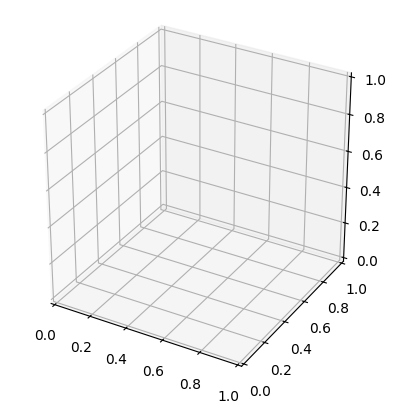

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
update = make_animation_update_function(ax, state_trajectory.T, time, b_r_s, with_added_mass=with_added_mass)

# Uncomment to show animation
#anim = FuncAnimation(fig, update, frames=len(time), interval=100, blit=False)
#HTML(anim.to_jshtml())  # Displays animation

### Bonus

The current method for distinguishing the cases is to animate it.
Can you find a simpler way to get that information from the data we have simulated?

In [40]:
import pythreejs as pj
from IPython.display import display

# Paths to the cubemap images (6 faces)
folder = "space_cubemap_high_res"
texture_paths = [
    f"./{folder}/px.png",  # Positive X
    f"./{folder}/nx.png",  # Negative X
    f"./{folder}/py.png",  # Positive Y
    f"./{folder}/ny.png",  # Negative Y
    f"./{folder}/pz.png",  # Positive Z
    f"./{folder}/nz.png",  # Negative Z
]

box_sides = 500
scene = pj.Scene()

camera = pj.PerspectiveCamera(position=[0, 0, 5], up=[0, 1, 0], aspect=1)
camera.lookAt([0, 0, 0])

# Create a CubeGeometry to represent the skybox
geometry = pj.BoxGeometry(width=box_sides, height=box_sides, depth=box_sides)

materials = []
for path in texture_paths:
    texture = pj.ImageTexture(imageUri=path)
    material = pj.MeshBasicMaterial(map=texture, side='BackSide')
    materials.append(material)

skybox = pj.Mesh(geometry, materials)
scene.add(skybox)

cubesat = pj.Mesh(
    pj.BoxGeometry(1, 1, 1),
    pj.MeshStandardMaterial(color='gray')
)
the_added_mass = pj.Mesh(
    pj.BoxGeometry(0.1, .1, .1),
    pj.MeshStandardMaterial(color="green")
)

cubesat.position = tuple(b_r_s)
the_added_mass.position = tuple(b_r_s + .5*np.ones((3,)))
axis_helper = pj.AxesHelper(size=5)
axis_helper.position = cubesat.position
axis_helper.quaternion = cubesat.quaternion
pivot = pj.Group()
pivot.add(cubesat)
pivot.add(the_added_mass)
pivot.add(axis_helper)


cubesat_position_track = pj.VectorKeyframeTrack(
    name=".position", times = time, values = (1e-7 * state_trajectory[0:3, :].T))
#cubesat_position_track = pj.VectorKeyframeTrack(
#    name=".position", times = time, values = (cube_center.T))
cubesat_rotation_track = pj.QuaternionKeyframeTrack(
    name = ".quaternion", times = time, values = rot)

cubesat_clip = pj.AnimationClip(tracks = [cubesat_position_track, cubesat_rotation_track])
cubesat_action = pj.AnimationAction(pj.AnimationMixer(pivot), cubesat_clip, pivot)

scene.add(pivot)

view_width = 800
view_height = 600
camera = pj.PerspectiveCamera(position=[10, 6, 10], aspect=view_width/view_height)

ambient_light = pj.AmbientLight(color='#ffffff', intensity=1.0)
key_light = pj.DirectionalLight(position=[0, 10, 0])
scene.add(key_light)
scene.add(ambient_light)

renderer = pj.Renderer(camera=camera, scene=scene, width=view_width, height=view_height)
controls = pj.OrbitControls(controlling=camera)
#cubesat_controls = pj.OrbitControls(controlling=cubesat)
renderer.controls = [controls]

renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(10.0, 6.0, 10.0), projectionMatrix=(1.0…

In [41]:
cubesat_action

AnimationAction(clip=AnimationClip(duration=10.0, tracks=(VectorKeyframeTrack(name='.position', times=array([0…